In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sn
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import seaborn as sns
from shapely.geometry import Point
import geopandas
from geodatasets import get_path
from shapely.geometry import Polygon

In [2]:
colnames_hurtt_nums = ['lon', 'lat', 'year', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22']
colnames_hurtt = ['nlon','nlat','yr','totalarea','lf_regrid','vu_regrid','vc_regrid','vp_regrid','su_regrid','sc_regrid','sp_regrid','us_regrid','uc_regrid','up_regrid','cs_regrid','cu_regrid','cp_regrid','ps_regrid','pu_regrid','pc_regrid','vs1_regrid','vs2_regrid','ss1_regrid','ss2_regrid','vs_regrid']

colnames_lulc = ['lon', 'lat', 'variable', 'year', 'cohort number', 'cohort source number', 'stand age', 'cohort area ', 
'potential natural vegetaion', 'current vegetation', 'vegetation subtype', 'lc state', 'previous years lc state', 
'fert flag', 'irrg flag', 'till flag', 'disturbance type', 'disturbance month', 'fire return interval',
'th1', 'th2', 'th3', 'th4', 'th5', 'th6', 'country']

colnames_max = ['lon', 'lat', 'variable', 'total land area', 'year', 'total number of cohorts',
                'number of natural cohorts', 'region']

In [3]:
potcohorts = pd.read_csv('/home/smmrrr/land_data_processing/support_files/cruHurtt3.2.1potlulccohrtsr_hurttlf.glb', names = colnames_lulc)
maxcohorts = pd.read_csv('/home/smmrrr/land_data_processing/support_files/cruHurtt3.2.1potmxcohrtsr_hurttlf.glb', names = colnames_max)



In [4]:
#### match pfts to the current veg, bin by standage for forests
conditions = [
 potcohorts['current vegetation'].isin([50, 49, 52, 53, 54, 55, 56]) 
    ,potcohorts['current vegetation'].isin([51, 47])
       , potcohorts['current vegetation'].isin([48, 46]) 
       ,potcohorts['current vegetation'] == 4
       ,potcohorts['current vegetation'] == 5
       ,potcohorts['current vegetation'] == 6
       ,potcohorts['current vegetation'] == 8
       ,potcohorts['current vegetation'] == 9
       ,potcohorts['current vegetation'] == 10
       ,potcohorts['current vegetation'] == 11
       ,potcohorts['current vegetation'] == 16
       ,potcohorts['current vegetation'] == 17
       ,potcohorts['current vegetation'] == 18
       ,potcohorts['current vegetation'] == 19
       ,potcohorts['current vegetation'] == 20
       ,potcohorts['current vegetation'] == 25
       ,potcohorts['current vegetation'] == 33
    ,potcohorts['current vegetation'].isin([7, 12, 13, 14, 22, 23, 24, 25, 26, 27, 28, 30, 31])
    ,potcohorts['current vegetation'].isin([15, 35, 29])
    ,potcohorts['current vegetation'].isin([2, 3])
    ,potcohorts['current vegetation'].isin([21])
]
values = [
          'crop', 
          'pasture', 
          'urban or suburban', 
"Boreal Forest", "Forested Boreal Wetlands", "Boreal Woodlands","Mixed Temperate Forests", 
               "Temperate Coniferous Forests", "Temperate Deciduous Forests", "Temperate Forested Wetlands", 
               "Tropical Evergreen Forests", "Tropical Forested Wetlands", "Tropical Deciduous Forests", "Xeromorphic Forests and Woodlands"
               ,"Tropical Forested Floodplains", "Temperate Forested Floodplains", "Temperate Broadleaved Evergreen Forests",
          'grass', 
          'shrub', 
          'tundra',
            'desert']

potcohorts['pft'] = np.select(conditions, values, default = 'other')


In [5]:
forests = ["Boreal Forest", "Forested Boreal Wetlands", "Boreal Woodlands","Mixed Temperate Forests", 
               "Temperate Coniferous Forests", "Temperate Deciduous Forests", "Temperate Forested Wetlands", 
               "Tropical Evergreen Forests", "Tropical Forested Wetlands", "Tropical Deciduous Forests", "Xeromorphic Forests and Woodlands"
               ,"Tropical Forested Floodplains", "Temperate Forested Floodplains", "Temperate Broadleaved Evergreen Forests"]

potcohorts['forest'] = potcohorts['pft'].isin(forests)
# potcohorts.loc[0]
potcohorts['forest'].value_counts()


False    39816
True     37803
Name: forest, dtype: int64

In [6]:
maxcohorts['id'] = maxcohorts['lon'].astype(str) + ' ' + maxcohorts['lat'].astype(str)
potcohorts['id'] = potcohorts['lon'].astype(str) + ' ' + potcohorts['lat'].astype(str)

In [7]:
### screen forests only - no mix shrub and forest grids

grids_to_keep = maxcohorts.loc[~maxcohorts['id'].isin(potcohorts.loc[potcohorts['forest']==False, 'id'])]

In [8]:
potcohorts.loc[potcohorts['id'].isin(grids_to_keep['id']),'pft'].value_counts()

Boreal Woodlands                           9350
Boreal Forest                              7713
Tropical Evergreen Forests                 6559
Mixed Temperate Forests                    5050
Xeromorphic Forests and Woodlands          2472
Tropical Deciduous Forests                 1779
Temperate Deciduous Forests                1765
Temperate Broadleaved Evergreen Forests    1381
Temperate Coniferous Forests               1225
Tropical Forested Wetlands                  189
Forested Boreal Wetlands                    158
Temperate Forested Wetlands                  63
Tropical Forested Floodplains                50
Temperate Forested Floodplains               49
Name: pft, dtype: int64

In [9]:
potcohorts['pft'].value_counts()

grass                                      20340
Boreal Woodlands                            9350
tundra                                      8464
Boreal Forest                               7713
shrub                                       6746
Tropical Evergreen Forests                  6559
Mixed Temperate Forests                     5050
desert                                      4266
Xeromorphic Forests and Woodlands           2472
Tropical Deciduous Forests                  1779
Temperate Deciduous Forests                 1765
Temperate Broadleaved Evergreen Forests     1381
Temperate Coniferous Forests                1225
Tropical Forested Wetlands                   189
Forested Boreal Wetlands                     158
Temperate Forested Wetlands                   63
Tropical Forested Floodplains                 50
Temperate Forested Floodplains                49
Name: pft, dtype: int64

In [9]:
grids_to_keep['region'].unique()
grids_to_keep.loc[grids_to_keep['region']==' AusEuropetralia']
grids_to_keep

,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id
52,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0
59,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0
73,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5
162,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5
173,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5
...,...,...,...,...,...,...,...,...,...
62576,179.0,-18.5,MXCOHRTS,98,-111,1,1,Asia,179.0 -18.5
62577,179.0,-17.0,MXCOHRTS,1924,-111,1,1,Asia,179.0 -17.0
62578,179.0,-16.5,MXCOHRTS,1318,-111,1,1,Asia,179.0 -16.5
62594,179.5,-17.0,MXCOHRTS,1704,-111,1,1,Asia,179.5 -17.0


In [10]:
grids_to_keep=grids_to_keep.merge(potcohorts[['id', 'pft']].drop_duplicates(), on = 'id', how = 'left')

In [11]:
grids_to_keep

,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,pft
0,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0,Temperate Broadleaved Evergreen Forests
1,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0,Temperate Broadleaved Evergreen Forests
2,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5,Tropical Evergreen Forests
3,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5,Boreal Forest
4,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5,Boreal Forest
...,...,...,...,...,...,...,...,...,...,...
30598,179.0,-18.5,MXCOHRTS,98,-111,1,1,Asia,179.0 -18.5,Tropical Evergreen Forests
30599,179.0,-17.0,MXCOHRTS,1924,-111,1,1,Asia,179.0 -17.0,Tropical Evergreen Forests
30600,179.0,-16.5,MXCOHRTS,1318,-111,1,1,Asia,179.0 -16.5,Tropical Evergreen Forests
30601,179.5,-17.0,MXCOHRTS,1704,-111,1,1,Asia,179.5 -17.0,Tropical Evergreen Forests


In [10]:
map_data = geopandas.GeoDataFrame(
    grids_to_keep, geometry=geopandas.points_from_xy(grids_to_keep.lon, grids_to_keep.lat)
    , crs="EPSG:4326"
)

map_data

,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,geometry
52,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0,POINT (-177.00000 -44.00000)
59,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0,POINT (-176.50000 -44.00000)
73,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5,POINT (-175.50000 -21.50000)
162,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5,POINT (-166.50000 64.50000)
173,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5,POINT (-166.00000 64.50000)
...,...,...,...,...,...,...,...,...,...,...
62576,179.0,-18.5,MXCOHRTS,98,-111,1,1,Asia,179.0 -18.5,POINT (179.00000 -18.50000)
62577,179.0,-17.0,MXCOHRTS,1924,-111,1,1,Asia,179.0 -17.0,POINT (179.00000 -17.00000)
62578,179.0,-16.5,MXCOHRTS,1318,-111,1,1,Asia,179.0 -16.5,POINT (179.00000 -16.50000)
62594,179.5,-17.0,MXCOHRTS,1704,-111,1,1,Asia,179.5 -17.0,POINT (179.50000 -17.00000)


In [39]:
360/12


30.0

In [11]:
# Constants for the grid
width = 30  # width of the rectangles in degrees (z)
height = 18  # height of the rectangles in degrees (y)

# Calculate the number of rectangles needed to cover the globe approximately
num_rect_lon = int(360 / width)
num_rect_lat = int(180 / height)

# Initialize list to store rectangles
rectangles = []

# Loop through the latitude and longitude
for j in range(num_rect_lon):
    for i in range(num_rect_lat):
        # Calculate the boundaries of the rectangle
        lon_min = -180 + j * width
        lat_min = -90 + i * height
        lon_max = lon_min + width
        lat_max = lat_min + height
        
        # Create a rectangle as a Polygon
        rect = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])
        
        # Append to the list of rectangles
        rectangles.append(rect)

# Convert the list of rectangles into a GeoDataFrame
gdf = geopandas.GeoDataFrame(geometry=rectangles)

# Set a coordinate reference system (CRS) as WGS84 (EPSG:4326)
gdf.crs = {'init': 'epsg:4326'}

# Save the GeoDataFrame to a file (optional)
#gdf.to_file("global_rectangles.shp", driver='ESRI Shapefile')
print(gdf)

                                              geometry
0    POLYGON ((-180.00000 -90.00000, -180.00000 -72...
1    POLYGON ((-180.00000 -72.00000, -180.00000 -54...
2    POLYGON ((-180.00000 -54.00000, -180.00000 -36...
3    POLYGON ((-180.00000 -36.00000, -180.00000 -18...
4    POLYGON ((-180.00000 -18.00000, -180.00000 0.0...
..                                                 ...
115  POLYGON ((150.00000 0.00000, 150.00000 18.0000...
116  POLYGON ((150.00000 18.00000, 150.00000 36.000...
117  POLYGON ((150.00000 36.00000, 150.00000 54.000...
118  POLYGON ((150.00000 54.00000, 150.00000 72.000...
119  POLYGON ((150.00000 72.00000, 150.00000 90.000...

[120 rows x 1 columns]


/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
map_data = map_data.to_crs(gdf.crs)
intersections = geopandas.sjoin(gdf, map_data, how='right')
# intersections.geometry.nunique()
intersections.index_left.nunique()

64

In [13]:
intersections

,index_left,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,geometry
52,2,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0,POINT (-177.00000 -44.00000)
59,2,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0,POINT (-176.50000 -44.00000)
73,3,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5,POINT (-175.50000 -21.50000)
162,8,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5,POINT (-166.50000 64.50000)
173,8,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5,POINT (-166.00000 64.50000)
...,...,...,...,...,...,...,...,...,...,...,...
62576,113,179.0,-18.5,MXCOHRTS,98,-111,1,1,Asia,179.0 -18.5,POINT (179.00000 -18.50000)
62577,114,179.0,-17.0,MXCOHRTS,1924,-111,1,1,Asia,179.0 -17.0,POINT (179.00000 -17.00000)
62578,114,179.0,-16.5,MXCOHRTS,1318,-111,1,1,Asia,179.0 -16.5,POINT (179.00000 -16.50000)
62594,114,179.5,-17.0,MXCOHRTS,1704,-111,1,1,Asia,179.5 -17.0,POINT (179.50000 -17.00000)


In [14]:
intersections.groupby('geometry')['index_left'].nunique()

geometry
POINT (-176.50000 -44.00000)    1
POINT (-177.00000 -44.00000)    1
POINT (-74.00000 -54.00000)     2
POINT (-73.00000 -54.50000)     1
POINT (-73.50000 -54.00000)     2
                               ..
POINT (146.00000 -42.00000)     1
POINT (146.00000 -42.50000)     1
POINT (145.50000 -42.50000)     1
POINT (145.00000 -43.00000)     1
POINT (146.50000 -44.00000)     1
Name: index_left, Length: 30603, dtype: int64

In [15]:
intersections['tt']=intersections.groupby('geometry')['index_left'].transform('cumcount')
intersections.loc[intersections['id']=='-73.5 -54.0']

,index_left,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,geometry,tt
12365,31,-73.5,-54.0,MXCOHRTS,1497,-111,1,1,South_America,-73.5 -54.0,POINT (-73.50000 -54.00000),0
12365,32,-73.5,-54.0,MXCOHRTS,1497,-111,1,1,South_America,-73.5 -54.0,POINT (-73.50000 -54.00000),1


In [16]:
intersections=intersections.loc[intersections['tt']==0]

In [17]:
n_per = intersections.groupby('index_left')['geometry'].nunique().reset_index()

len(n_per.loc[n_per['geometry']<1000])
as_is = n_per.loc[n_per['geometry']>=1000]
consolidate = n_per.loc[n_per['geometry']<1000]
len(consolidate)

52

In [18]:
as_is
consolidate

cumulative_sum = 0
group_number = 1
groups = []  # List to hold the group number for each row

for number in consolidate['geometry']:
    cumulative_sum += number
    if cumulative_sum > 1200:
        group_number += 1
        cumulative_sum = number  # Reset cumulative sum to the current number
    groups.append(group_number)

consolidate['group'] = groups
consolidate

/tmp/ipykernel_1469259/964538442.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidate['group'] = groups


,index_left,geometry,group
0,2,2,1
1,3,1,1
2,8,277,1
3,16,8,1
4,17,355,1
5,18,966,2
6,24,8,2
7,25,158,2
8,26,500,3
9,27,732,4


In [19]:
con_group_n = max(consolidate['group'])+1
as_is['group'] = np.arange(con_group_n, con_group_n+len(as_is))

/tmp/ipykernel_1469259/3825702886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_is['group'] = np.arange(con_group_n, con_group_n+len(as_is))


In [20]:
len(as_is)
as_is

,index_left,geometry,group
14,34,1194,19
17,37,1506,20
21,44,1018,21
33,67,1385,22
34,68,1095,23
40,78,1415,24
44,88,1060,25
48,96,1487,26
50,98,1848,27
56,107,1007,28


In [21]:
intersections=intersections.merge(pd.concat([consolidate, as_is],axis = 0), on = 'index_left')

In [22]:
intersections

,index_left,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,geometry_x,tt,geometry_y,group
0,2,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0,POINT (-177.00000 -44.00000),0,2,1
1,2,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0,POINT (-176.50000 -44.00000),0,2,1
2,3,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5,POINT (-175.50000 -21.50000),0,1,1
3,8,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5,POINT (-166.50000 64.50000),0,277,1
4,8,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5,POINT (-166.00000 64.50000),0,277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30598,112,177.5,-38.5,MXCOHRTS,2427,-111,1,1,Australia,177.5 -38.5,POINT (177.50000 -38.50000),0,122,17
30599,112,177.5,-38.0,MXCOHRTS,2171,-111,1,1,Australia,177.5 -38.0,POINT (177.50000 -38.00000),0,122,17
30600,112,178.0,-39.0,MXCOHRTS,590,-111,1,1,Australia,178.0 -39.0,POINT (178.00000 -39.00000),0,122,17
30601,112,178.0,-38.5,MXCOHRTS,1615,-111,1,1,Australia,178.0 -38.5,POINT (178.00000 -38.50000),0,122,17


In [23]:
map_data=map_data.merge(intersections[['id', 'group']], on = 'id')
map_data['group'] = map_data['group'].astype(str)

<GeoAxes: >

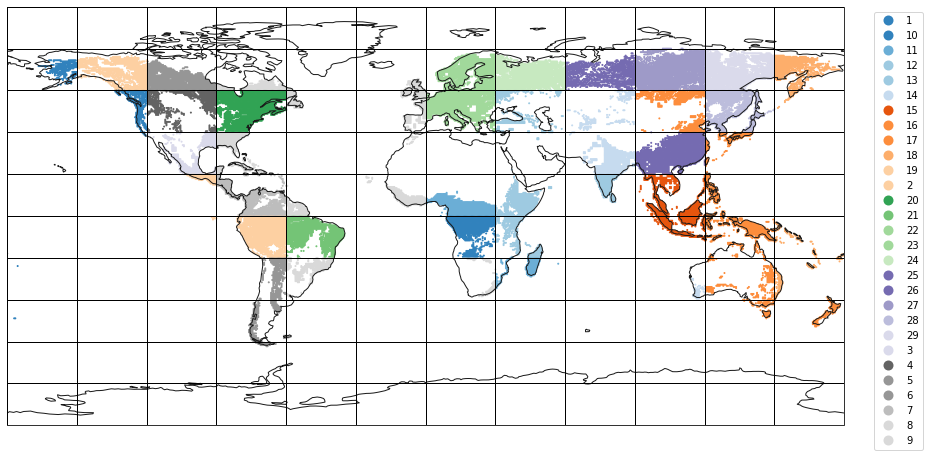

In [24]:

fig, axs = plt.subplots(nrows=1, ncols=1,figsize = (15, 12)
                      ,subplot_kw=dict(projection=ccrs.PlateCarree()))

axs.coastlines(color="0.1")
# axs[1].coastlines(color="0.1")


plot0 = map_data.plot(ax = axs 
                                         ,cmap = 'tab20c'
                                         , column = 'group', legend = True, 
                                         # vmin = 0, vmax = 20000, 
                                                          markersize = 1,
                       legend_kwds={'bbox_to_anchor': (1.1, 1)  }                
                      # legend_kwds={ "location":"bottom" , "pad":0.05}
                                        )
gdf.boundary.plot(ax=axs, color='k', linestyle='-', linewidth=1)
# legend = axs.legend(title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))

<GeoAxes: >

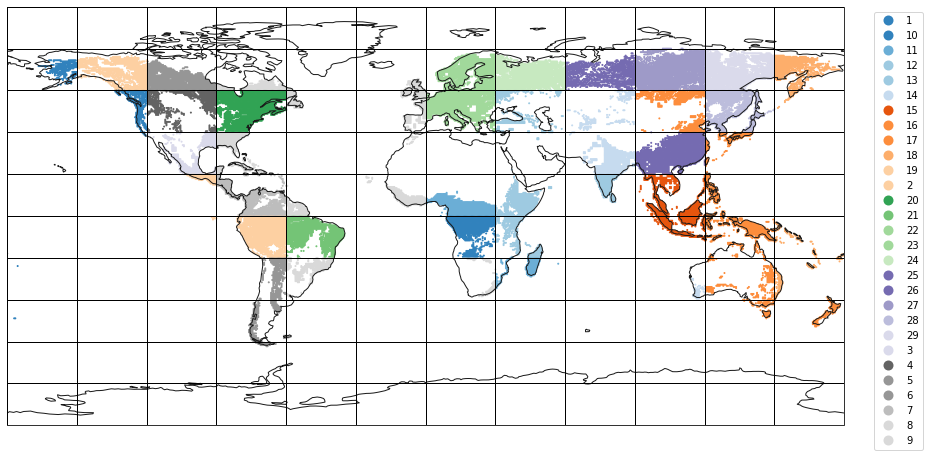

In [27]:

fig, axs = plt.subplots(nrows=1, ncols=1,figsize = (15, 12)
                      ,subplot_kw=dict(projection=ccrs.PlateCarree()))

axs.coastlines(color="0.1")
# axs[1].coastlines(color="0.1")


plot0 = map_data.plot(ax = axs 
                                         ,cmap = 'tab20c'
                                         , column = 'group', legend = True, 
                                         # vmin = 0, vmax = 20000, 
                                                          markersize = 1,
                       legend_kwds={'bbox_to_anchor': (1.1, 1)  }                
                      # legend_kwds={ "location":"bottom" , "pad":0.05}
                                        )
gdf.boundary.plot(ax=axs, color='k', linestyle='-', linewidth=1)
# legend = axs.legend(title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))

<GeoAxes: >

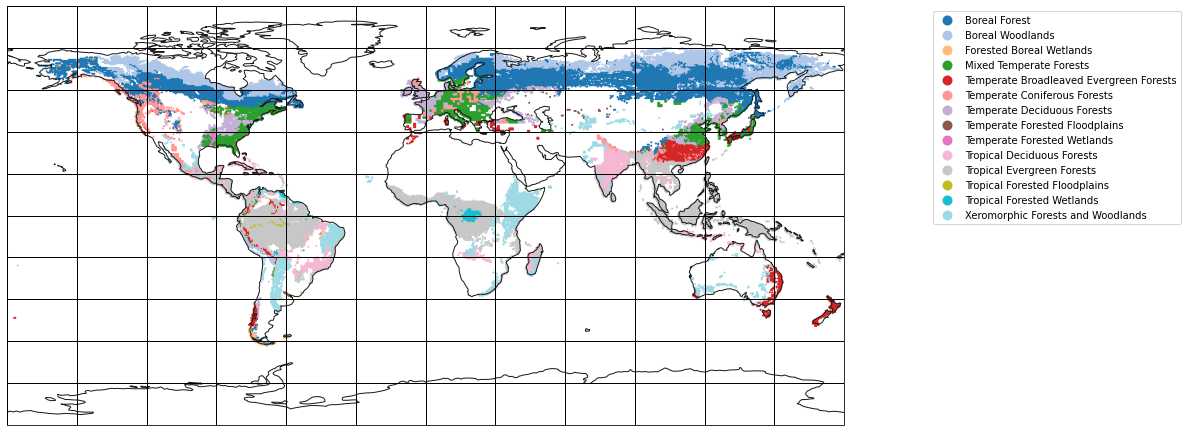

In [97]:

fig, axs = plt.subplots(nrows=1, ncols=1,figsize = (15, 12)
                      ,subplot_kw=dict(projection=ccrs.PlateCarree()))

axs.coastlines(color="0.1")
# axs[1].coastlines(color="0.1")


plot0 = map_data.plot(ax = axs 
                                         ,cmap = 'tab20'
                                         , column = 'pft', legend = True, 
                                         # vmin = 0, vmax = 20000, 
                                                          markersize = 1,
                       legend_kwds={'bbox_to_anchor': (1.1, 1)  }                
                      # legend_kwds={ "location":"bottom" , "pad":0.05}
                                        )
gdf.boundary.plot(ax=axs, color='k', linestyle='-', linewidth=1)
# legend = axs.legend(title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))

In [141]:
map_data.groupby(['group','region'])['id'].count().reset_index()

,group,region,id
0,1,Asia,1
1,1,Australia,2
2,1,North_America,640
3,10,Africa,812
4,11,Africa,886
5,11,Asia,2
6,11,Europe,2
7,12,Africa,967
8,12,Asia,23
9,13,Asia,431


In [29]:
map_data

,lon,lat,variable,total land area,year,total number of cohorts,number of natural cohorts,region,id,pft,geometry,group
0,-177.0,-44.0,MXCOHRTS,991,-111,1,1,Australia,-177.0 -44.0,Temperate Broadleaved Evergreen Forests,POINT (-177.00000 -44.00000),1
1,-176.5,-44.0,MXCOHRTS,743,-111,1,1,Australia,-176.5 -44.0,Temperate Broadleaved Evergreen Forests,POINT (-176.50000 -44.00000),1
2,-175.5,-21.5,MXCOHRTS,758,-111,1,1,Asia,-175.5 -21.5,Tropical Evergreen Forests,POINT (-175.50000 -21.50000),1
3,-166.5,64.5,MXCOHRTS,1174,-111,1,1,North_America,-166.5 64.5,Boreal Forest,POINT (-166.50000 64.50000),1
4,-166.0,64.5,MXCOHRTS,1318,-111,1,1,North_America,-166.0 64.5,Boreal Forest,POINT (-166.00000 64.50000),1
...,...,...,...,...,...,...,...,...,...,...,...,...
30598,179.0,-18.5,MXCOHRTS,98,-111,1,1,Asia,179.0 -18.5,Tropical Evergreen Forests,POINT (179.00000 -18.50000),18
30599,179.0,-17.0,MXCOHRTS,1924,-111,1,1,Asia,179.0 -17.0,Tropical Evergreen Forests,POINT (179.00000 -17.00000),18
30600,179.0,-16.5,MXCOHRTS,1318,-111,1,1,Asia,179.0 -16.5,Tropical Evergreen Forests,POINT (179.00000 -16.50000),18
30601,179.5,-17.0,MXCOHRTS,1704,-111,1,1,Asia,179.5 -17.0,Tropical Evergreen Forests,POINT (179.50000 -17.00000),18


In [25]:
### make 29 folders for data storage
### save lon/lat 1 and 2 decimals
### create extract programs
# dir_save = '/home/smmrrr/TEM/TEM_toolkit/large_ensemble_region_splits/region_'
dir_save = '/home/smmrrr/TEM/TEM_toolkit/cru_region_splits/region_'
for ngroup in range(1, 30):
    ngroup=str(ngroup)
    lonlat = map_data.loc[map_data['group']==ngroup, ['lon','lat']]
    lonlat.to_csv(dir_save+ngroup+'/lon_lat_1dec.txt',float_format='%.1f'
                    ,index = False, header = False)
    lonlat.to_csv(dir_save+ngroup+'/lon_lat_2dec.txt',float_format='%.2f'
                    ,index = False, header = False)
    

In [33]:
dir_save+ngroup+'lon_lat2dec.txt'

'/home/smmrrr/TEM/TEM_toolkit/large_ensemble_region_splits/region_28lon_lat2dec.txt'

In [21]:
maxcohorts['look_up'] = maxcohorts.groupby('chunk')['count'].transform('min')

In [22]:
maxcohorts.loc[(maxcohorts['lon'].between(-73,-53 )) 
                        &
                       (maxcohorts['lat'].between(-10,0)), 'look_up'].unique()

array([12530, 13783, 15036, 16289, 17542])

In [13]:
maxcohorts.loc[maxcohorts['-180.0000'] == -156.5]

,-180.0000,65.0000,MXCOHRTS,1040,-111,1,1.1,Asia
622,-156.5,19.5,MXCOHRTS,332,-111,2,2,North_America
623,-156.5,20.5,MXCOHRTS,2299,-111,2,2,North_America
624,-156.5,57.0,MXCOHRTS,927,-111,1,1,North_America
625,-156.5,57.5,MXCOHRTS,1649,-111,1,1,North_America
626,-156.5,58.0,MXCOHRTS,1626,-111,1,1,North_America
627,-156.5,58.5,MXCOHRTS,1603,-111,1,1,North_America
628,-156.5,59.0,MXCOHRTS,1580,-111,1,1,North_America
629,-156.5,59.5,MXCOHRTS,1557,-111,1,1,North_America
630,-156.5,60.0,MXCOHRTS,1533,-111,1,1,North_America
631,-156.5,60.5,MXCOHRTS,1510,-111,1,1,North_America


In [17]:
g_hurtt_hist_input = pd.read_table('/home/smmrrr/TEM_Climate_Data/LULCC/output_files/historical/transitionslf_total_exp.txt'
                                   , delim_whitespace=True, names = colnames_hurtt)


In [8]:
potcohorts = potcohorts.set_index(['lon', 'lat'])
g_hurtt_hist_input = g_hurtt_hist_input.set_index(['lon', 'lat'])
potcohorts.index

NameError: name 'g_hurtt_fut_input' is not defined

In [24]:
potcohorts

col1  col2  col3  col4  col5  col6  col7  col8  col9  \
lon    lat                                                                
-180.0 65.0   LULCCHRT   -111     1     1  3000  1040     3     3     3   
       65.5   LULCCHRT   -111     1     1  3000  1030     3     3     3   
       66.0   LULCCHRT   -111     1     1  3000  1245     2     2     2   
       66.5   LULCCHRT   -111     1     1  3000  1220     2     2     2   
       67.0   LULCCHRT   -111     1     1  3000  1195     2     2     2   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   
 179.5 67.5   LULCCHRT   -111     1     1  3000  1170     2     2     2   
       68.0   LULCCHRT   -111     1     1  3000  1145     2     2     2   
       68.5   LULCCHRT   -111     1     1  3000  1120     2     2     2   
       70.5   LULCCHRT   -111     1     1  3000   225     3     3     3   
       71.0   LULCCHRT   -111     1     1  3000   993     2     2     2   

             col10  ...  col15  col16  col17  col18  col19  col20  col21  \
lon    lat          ...                                                    
-180.0 65.0      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       65.5      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       66.0      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       66.5      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       67.0      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
 179.5 67.5      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       68.0      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       68.5      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       70.5      0  ...      0      0   2000    0.0    0.0    0.0    0.0   
       71.0      0  ...      0      0   2000    0.0    0.0    0.0    0.0   

             col22  col23    col24  
lon    lat                          
-180.0 65.0    0.0    0.0   Russia  
       65.5    0.0    0.0   Russia  
       66.0    0.0    0.0   Russia  
       66.5    0.0    0.0   Russia  
       67.0    0.0    0.0   Russia  
...            ...    ...      ...  
 179.5 67.5    0.0    0.0   Russia  
       68.0    0.0    0.0   Russia  
       68.5    0.0    0.0   Russia  
       70.5    0.0    0.0   Russia  
       71.0    0.0    0.0   Russia  

[77619 rows x 24 columns]

In [30]:
# g_hurtt_hist_input.loc[g_hurtt_hist_input['year'] == 1764]
g_hurtt_hist_input.loc[(g_hurtt_hist_input['lat'] == 65.0) & (g_hurtt_hist_input['lon'] == -180)
                       , 'year'].unique().tofile('/home/smmrrr/data2.csv', sep = ',') 


In [3]:
# potcohorts.reindex(index = g_hurtt_fut_input.index)

In [26]:
print(potcohorts['65.0000'].nunique())
print(g_hurtt_hist_input['-16.5000'].nunique())

280
280


In [4]:

hist = pd.read_table(
"/home/smmrrr/TEM_Climate_Data/LULCC/output_files/historical/transitionslf_total_exp.txt"
    , delim_whitespace=True, names = colnames_hurtt)


In [10]:
colnames_hurtt

['nlon',
 'nlat',
 'yr',
 'totalarea',
 'lf_regrid',
 'vu_regrid',
 'vc_regrid',
 'vp_regrid',
 'su_regrid',
 'sc_regrid',
 'sp_regrid',
 'us_regrid',
 'uc_regrid',
 'up_regrid',
 'cs_regrid',
 'cu_regrid',
 'cp_regrid',
 'ps_regrid',
 'pu_regrid',
 'pc_regrid',
 'vs1_regrid',
 'vs2_regrid',
 'ss1_regrid',
 'ss2_regrid',
 'vs_regrid']

In [12]:
print(np.array(hist.loc[( hist['year'] == 1750 )&
        ( hist['lon'] == -156.5 ) & 
        ( hist['lat'] == 20.5 )
        ]))

print(np.array(hist.loc[( hist['year'] == 1500 )&
        ( hist['lon'] == -156.5 ) & 
        ( hist['lat'] == 20.5 )
        ]))

[[-1.5650e+02  2.0500e+01  1.7500e+03  9.0573e-05  1.0000e+00  0.0000e+00
   0.0000e+00  6.8350e-05  4.2404e-06  0.0000e+00  1.3452e-07  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   1.7848e-05  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00]]
[[-1.5650e+02  2.0500e+01  1.5000e+03  4.2582e-06  1.0000e+00  1.1747e-07
   0.0000e+00  0.0000e+00  1.6240e-06  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  2.5153e-06  0.0000e+00  1.4520e-09  0.0000e+00
   0.0000e+00]]


In [ ]:

hist = pd.read_table(
"/home/smmrrr/TEM_Climate_Data/LULCC/output_files/historical/transitionslf_total_exp.txt"
    , delim_whitespace=True, names = colnames_hurtt)



In [10]:
hist.loc[( hist['year'] == 1501 )&
        ( hist['lon'] == -156.5 )# & 
        #( hist['year'] == 1501 )
        ]

,lon,lat,year,col1,col2,col3,col4,col5,col6,col7,...,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22
726446,-156.5,19.5,1501,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
727611,-156.5,20.5,1501,0.000004,1.0,0.0,0.0,0.0,0.000002,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,1.439000e-09,0.0,0.0
728776,-156.5,57.0,1501,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
729941,-156.5,57.5,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
731106,-156.5,58.0,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
732271,-156.5,58.5,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
733436,-156.5,59.0,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
734601,-156.5,59.5,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
735766,-156.5,60.0,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0
736931,-156.5,60.5,1501,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0


In [4]:
g_hurtt_fut_input = pd.read_table('/home/smmrrr/TEM_Climate_Data/LULCC/output_files/ssp126/transitionslf_total_exp.txt', delim_whitespace=True, names = colnames_hurtt)



In [5]:
print(
  hist['year'].max()
    ,hist['year'].min()
        ,  g_hurtt_fut_input['year'].max()
    ,g_hurtt_fut_input['year'].min()

)

2014 850 2099 2015


In [15]:
g_hurtt_fut_input.loc[0]

lon      -180.00
lat       -16.50
year     2015.00
col1        0.00
col2        0.25
col3        0.00
col4        0.00
col5        0.00
col6        0.00
col7        0.00
col8        0.00
col9        0.00
col10       0.00
col11       0.00
col12       0.00
col13       0.00
col14       0.00
col15       0.00
col16       0.00
col17       0.00
col18       0.00
col19       0.00
col20       0.00
col21       0.00
col22       0.00
Name: 0, dtype: float64

In [29]:
g_hurtt_fut_input.describe()

,lon,lat,year,col1,col2,col3,col4,col5,col6,col7,...,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22
count,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,...,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3.073551e+06,3073551.0
mean,-4.161192e+01,2.722879e+01,2.057000e+03,1.795753e-02,9.621537e-01,1.475661e-07,9.650776e-05,1.713918e-05,2.502432e-05,1.692818e-03,...,1.437963e-05,1.683090e-05,3.870093e-04,1.374567e-05,1.490016e-04,3.722339e-04,2.561934e-04,8.020265e-03,5.152225e-03,0.0
std,5.896480e+01,3.223832e+01,2.453572e+01,7.398626e-02,1.382465e-01,8.711942e-06,8.349909e-04,2.139181e-04,1.152844e-04,5.804256e-03,...,6.356863e-05,1.530344e-04,2.142511e-03,5.557790e-05,9.314019e-04,1.845129e-03,1.443126e-03,6.937807e-02,2.368207e-02,0.0
min,-1.800000e+02,-5.600000e+01,2.015000e+03,0.000000e+00,2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,-9.100000e+01,1.000000e+00,2.036000e+03,1.067050e-05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,-5.450000e+01,3.150000e+01,2.057000e+03,1.855700e-03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.569100e-08,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,1.750000e+01,5.500000e+01,2.078000e+03,9.573300e-03,1.000000e+00,0.000000e+00,5.226900e-10,0.000000e+00,7.519250e-06,1.517900e-04,...,2.137400e-06,0.000000e+00,1.481000e-05,4.108800e-06,6.534300e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,4.350000e+01,8.350000e+01,2.099000e+03,9.999000e-01,1.000000e+00,1.370300e-03,1.410100e-01,2.294100e-02,7.783400e-03,2.053000e-01,...,8.331000e-03,1.299300e-02,1.487000e-01,3.908100e-03,8.422200e-02,5.908700e-01,7.713100e-02,9.999000e-01,9.627400e-01,0.0


In [9]:
hurtt_hist_input = pd.read_table('/home/smmrrr/TEM_Climate_Data/LULCC/output_files/historical/transitionslf_total_exp_usa48.txt', delim_whitespace=True)



In [13]:
hurtt_hist_input

,-125.0000,42.5000,850,0.0000e+00,2.5000e-01,0.0000e+00.1,0.0000e+00.2,0.0000e+00.3,0.0000e+00.4,0.0000e+00.5,...,0.0000e+00.11,0.0000e+00.12,0.0000e+00.13,0.0000e+00.14,0.0000e+00.15,0.0000e+00.16,0.0000e+00.17,0.0000e+00.18,0.0000e+00.19,0.0000e+00.20
0,-125.0,42.5,851,0.000000,0.25,0.0,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,-125.0,42.5,852,0.000000,0.25,0.0,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,-125.0,42.5,853,0.000000,0.25,0.0,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,-125.0,42.5,854,0.000000,0.25,0.0,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,-125.0,42.5,855,0.000000,0.25,0.0,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938859,-67.5,44.5,2010,0.002045,1.00,0.0,0.000000,1.591700e-06,0.000015,0.000000,...,3.956000e-07,0.000054,0.0,0.000002,0.0,0.001228,0.0,0.000684,0.0,0.0
3938860,-67.5,44.5,2011,0.002834,1.00,0.0,0.000002,2.445400e-06,0.000015,0.000094,...,3.899600e-07,0.000000,0.0,0.000002,0.0,0.001460,0.0,0.001162,0.0,0.0
3938861,-67.5,44.5,2012,0.002180,1.00,0.0,0.000000,6.231700e-07,0.000054,0.000000,...,7.403400e-07,0.000054,0.0,0.000006,0.0,0.001078,0.0,0.000773,0.0,0.0
3938862,-67.5,44.5,2013,0.003124,1.00,0.0,0.000003,1.673300e-06,0.000016,0.000155,...,4.197100e-07,0.000000,0.0,0.000002,0.0,0.001359,0.0,0.001502,0.0,0.0


In [15]:
usa = pd.read_table('/home/smmrrr/TEM_Climate_Data/LULCC/support_files/lonlathurttlf_usa48.txt', delim_whitespace = True)

In [16]:
usa

,-125,42.5
0,-125.0,47.5
1,-125.0,48.0
2,-124.5,40.0
3,-124.5,40.5
4,-124.5,41.0
...,...,...
3375,-68.0,44.0
3376,-68.0,44.5
3377,-68.0,45.0
3378,-68.0,45.5


In [14]:
hurtt_hist_input["42.5000"].nunique()

48

In [4]:
xr.open_dataset('/home/smmrrr/TEM_Climate_Data/LULCC/hurtt_files/states.nc',decode_times=False)

<xarray.Dataset>
Dimensions:     (time: 1166, lat: 720, lon: 1440, bounds: 2)
Coordinates:
  * time        (time) float64 0.0 1.0 2.0 3.0 ... 1.163e+03 1.164e+03 1.165e+03
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/16)
    primf       (time, lat, lon) float32 ...
    primn       (time, lat, lon) float32 ...
    secdf       (time, lat, lon) float32 ...
    secdn       (time, lat, lon) float32 ...
    urban       (time, lat, lon) float32 ...
    c3ann       (time, lat, lon) float32 ...
    ...          ...
    pastr       (time, lat, lon) float32 ...
    range       (time, lat, lon) float32 ...
    secmb       (time, lat, lon) float32 ...
    secma       (time, lat, lon) float32 ...
    lat_bounds  (lat, bounds) float64 ...
    lon_bounds  (lon, bounds) float64 ...
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [6]:
hist = xr.open_dataset('/home/smmrrr/TEM_Climate_Data/LULCC/hurtt_files/CMIP6/historical/transitions.nc',decode_times=False)




In [7]:
hist

<xarray.Dataset>
Dimensions:         (time: 1165, lat: 720, lon: 1440, bounds: 2)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 ... 1.162e+03 1.163e+03 1.164e+03
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/120)
    primf_to_secdn  (time, lat, lon) float32 ...
    primf_to_urban  (time, lat, lon) float32 ...
    primf_to_c3ann  (time, lat, lon) float32 ...
    primf_to_c4ann  (time, lat, lon) float32 ...
    primf_to_c3per  (time, lat, lon) float32 ...
    primf_to_c4per  (time, lat, lon) float32 ...
    ...              ...
    primn_bioh      (time, lat, lon) float32 ...
    secmf_bioh      (time, lat, lon) float32 ...
    secyf_bioh      (time, lat, lon) float32 ...
    secnf_bioh      (time, lat, lon) float32 ...
    lat_bounds      (lat, bounds) float64 ...
    lon_bounds      (lon, bounds) float64 ...
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [9]:
air2d = hist.isel(time=500)

air2d

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440, bounds: 2)
Coordinates:
    time            float64 500.0
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/120)
    primf_to_secdn  (lat, lon) float32 ...
    primf_to_urban  (lat, lon) float32 ...
    primf_to_c3ann  (lat, lon) float32 ...
    primf_to_c4ann  (lat, lon) float32 ...
    primf_to_c3per  (lat, lon) float32 ...
    primf_to_c4per  (lat, lon) float32 ...
    ...              ...
    primn_bioh      (lat, lon) float32 ...
    secmf_bioh      (lat, lon) float32 ...
    secyf_bioh      (lat, lon) float32 ...
    secnf_bioh      (lat, lon) float32 ...
    lat_bounds      (lat, bounds) float64 90.0 89.75 89.75 ... -89.75 -90.0
    lon_bounds      (lon, bounds) float64 -180.0 -179.8 -179.8 ... 179.8 180.0
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [24]:
# air.isel(time=10, lon=[10, 11]).plot(y="lat", hue="lon")
hist_count = hist['secmf_harv'].sum(dim = 'time')

# hist.isel(time=500)['primf_harv'].plot()


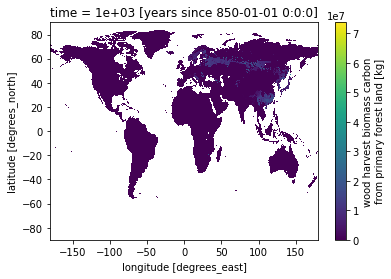

In [28]:
hist.isel(time=1000)['primf_bioh'].plot()

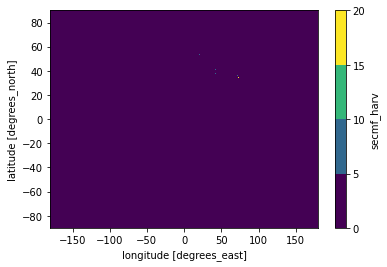

In [26]:
hist_count.plot(levels = 5)

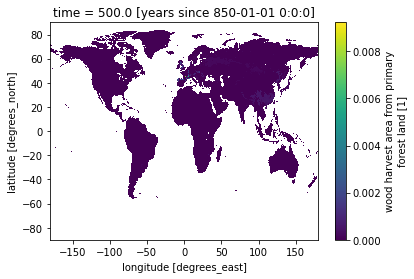

In [13]:
hist.isel(time=500)['primf_harv'].plot()


In [15]:
xr.open_dataset("/home/smmrrr/TEM_Climate_Data/LULCC/hurtt_files/states.nc",decode_times=False)

<xarray.Dataset>
Dimensions:     (time: 1166, lat: 720, lon: 1440, bounds: 2)
Coordinates:
  * time        (time) float64 0.0 1.0 2.0 3.0 ... 1.163e+03 1.164e+03 1.165e+03
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/16)
    primf       (time, lat, lon) float32 ...
    primn       (time, lat, lon) float32 ...
    secdf       (time, lat, lon) float32 ...
    secdn       (time, lat, lon) float32 ...
    urban       (time, lat, lon) float32 ...
    c3ann       (time, lat, lon) float32 ...
    ...          ...
    pastr       (time, lat, lon) float32 ...
    range       (time, lat, lon) float32 ...
    secmb       (time, lat, lon) float32 ...
    secma       (time, lat, lon) float32 ...
    lat_bounds  (lat, bounds) float64 ...
    lon_bounds  (lon, bounds) float64 ...
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [5]:
720*360

259200

In [7]:
temarea = pd.read_csv(
    '~/TEM_Climate_Data/LULCC/support_files/igsmtbaselv0.5x0.5degree.glb' 
           ,names = [ 'lon', 'lat', 'Variable', 'Area', 'Elev','Area_Name']
                )

In [8]:
temarea = temarea[[ 'lon', 'lat', 'Area']]

In [13]:
temarea.to_csv('~/TEM_Climate_Data/LULCC/support_files/temarealf.txt', header = False, index = False)